#**Negative Binomial Regression**

In the previos step we saw how the poisson distribution was limited by the assumption that the $\mu=\sigma$. Negative binomial regression is a popular generalization of Poisson regression because it loosens the highly restrictive assumption that the variance is equal to the mean made by the Poisson model. The traditional negative binomial regression model, commonly known as NB2, is based on the Poisson-gamma mixture distribution. This model is popular because it models the Poisson heterogeneity with a gamma distribution.


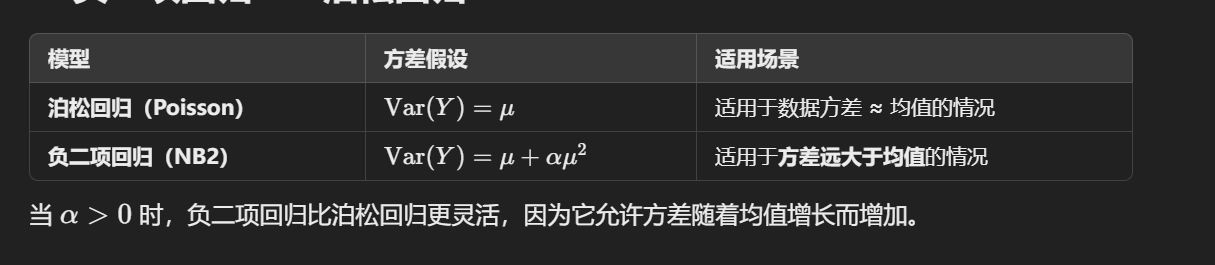

A characteristic of the Poisson distribution is that its mean is equal to its variance. In certain circumstances, it will be found that the observed variance is greater than the mean; this is known as overdispersion and indicates that the model is not appropriate. A common reason is the omission of relevant explanatory variables, or dependent observations.

If we go back to the characteristics of the various GLM family of distributions,Figure 1, we see that the negative binomial has a mean similar to the poisson but has the following variance:

 $$v(\mu)= \mu+\alpha.\mu^2~~~~~~~(1)$$



</br>

<figure>
<center>
<img src='https://www.computing.dcu.ie/~amccarren/mcm_images/GLM_models.png' />
<figcaption>Figure 1: Link function options</figcaption>
</center>
</figure>

[1] Outlines that there are 2 ways to calculate the variance in practice and they are the calculation outline in equation (1) above and that outlined in equation (2)
 $$v(\mu)= \mu+\alpha.\mu+(1+\alpha).\mu~~~~~~~(2)$$

Equation 1 is know as the NB2 model and euation 2 is know as the NB1 model.
The following strategy is outlined in [Toward Science](https://towardsdatascience.com/negative-binomial-regression-f99031bb25b4) to implement the NB2 regression strategy:

* STEP 1: Fit the Poisson regression model on the data set. This will give us the vector of fitted rates λ.
* STEP 2: Fit the aux OLS regression model on the data set. This will give us the value of α.
* STEP 3: Use the α from STEP 2 to fit the NB2 regression model to the data set.
* STEP 4: Use the fitted NB2 model to make predictions about expected counts on the test data set.
* STEP 5: Test the goodness-of-fit of the NB2 model.

Now the following example is one described in the [toward Science](https://towardsdatascience.com/negative-binomial-regression-f99031bb25b4) and basically revolves around getting an estimate for $\alpha$ in the variance equation above.

Lets have a look at some python code.

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/My Drive/dcu/future Learn_v2/MOOC 5 - CA683 - Point Estimation and Future Impact Calculation/M5 Colab Files/Data")
!ls

Mounted at /content/drive
calories.csv			  poisson_predictions.csv
exercise.csv			  SN_m_tot_V2.0.csv
nyc_bb_bicyclist_counts.csv	  student_mat.csv
nyc_bb_bicyclist_counts_test.csv  Telco-Customer-Churn.csv


Import the data for this example from [here](https://www.computing.dcu.ie/~amccarren/mcm_data/nyc_bb_bicyclist_counts.csv), as in the previous step, and extract the day, day of the week and  month from the date index.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from patsy import dmatrices
import matplotlib.pyplot as plt

df = pd.read_csv('nyc_bb_bicyclist_counts.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])
df=df.reset_index()
df=df.set_index('Date')
ds = df.index.to_series()
df['MONTH'] = ds.dt.month
df['DAY_OF_WEEK'] = ds.dt.dayofweek
df['DAY'] = ds.dt.day
#create the training and testing data sets
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

#Setup the regression expression in patsy notation. We are telling patsy that BB_COUNT is our dependent variable and it depends on the regression variables: DAY, DAY_OF_WEEK, MONTH, HIGH_T, LOW_T and PRECIP
expr = """BB_COUNT ~ DAY  + DAY_OF_WEEK + MONTH + HIGH_T + LOW_T + PRECIP"""

#Set up the X and y matrices for the training and testing data sets
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')


Training data set length=167
Testing data set length=47


So in order to implement the NB2 strategy we first implement a normal Poisson regression to get an estimate of the $\lambda$ rate. [2] explains that you can use the following equation to find our value for $\alpha$:

$$\frac{(y_i-\lambda_i)^2-y_i}{\lambda_i}=\alpha.\lambda_i +0$$

Now remember the $y_i$ in this equation are original counts and the $\lambda's$ are the predicted $\mu's$from the poisson regression.







In [ ]:
import statsmodels.api as sm
from scipy.stats import chi2

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
link_func = sm.families.links.log()
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson(link_func)).fit()

print("chi-square p-value test Ho model vs saturated model If < 0.05 reject Ho（H0：泊松回归模型与饱和模型之间的差异不显著（即，泊松回归模型拟合良好）。）, model is a poor fit. :",1-chi2.cdf(poisson_training_results.pearson_chi2,(poisson_training_results.df_resid-len(X_train.columns))))
print(poisson_training_results.summary())
#print(y.describe())

Now we have done everything the same as the previous but we will get estimates of $\mu$



In [ ]:
#print out the fitted rate vector
print(poisson_training_results.mu)

[1883.24277695 2640.98005135 2527.0298481  2676.43908443 1171.60767781
 1818.47838169 2750.10462137 3179.77101356 3246.63189021 2874.75347205
 2420.38477246 3353.5915857  2713.03315228 2791.99396208 2053.96967199
 1583.75929439 1776.47425522 2624.77379721 2432.36595373 1066.19476058
 1676.96202062 2442.79337417 3632.71610796 2277.97251486 3305.23069522
 2530.70349535 2298.26453392 2470.5548524   241.49591023 1947.2838313
 1869.59511389 2992.33471751 2287.85718271 2343.53919237 2629.91943773
 2642.95169084 3372.608791   3934.57034505 3465.83220253 2226.12604182
 2417.49169421 1543.63438522 2601.6543851  2451.62246395 1313.75303002
 2717.81824394 2492.30495689 1927.76484716 2050.74223511 3036.514269
 2709.29397108 2771.25302321 2416.24236799 2441.61343126 3237.17040295
 3551.33165937 3582.67749564 2598.83920942 2617.11221463 2136.24957965
  870.20135398 2813.3546377  1355.3051685  2894.32016711 2905.91396248
 2958.57954856 2605.6103982  1137.28162629 2852.25568074 3043.48081659
 2709.514

In the following code snippet we do a comparsion of the  actual counts vs the predicted counts. You can see the model is not really a good fit and would lead us to believe something is missing.

In [ ]:
#Add the λ vector as a new column called 'BB_LAMBDA' to the Data Frame of the training data set
df_train['BB_LAMBDA'] = poisson_training_results.mu

#add a derived column called 'AUX_OLS_DEP' to the pandas Data Frame. This new column will store the values of the dependent variable of the OLS regression
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['BB_COUNT'] - x['BB_LAMBDA'])**2 - x['BB_COUNT']) / x['BB_LAMBDA'], axis=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Now we must check tha the $\alpha$ we have estimated above is significant. The print out alpha and the Pvalue $<0.01$ and is significant.

In [ ]:

#Configure and fit the OLSR model
aux_olsr_results = sm.OLS(df_train['AUX_OLS_DEP'],df_train['BB_LAMBDA']).fit()

#Print the regression params
print(aux_olsr_results.params,aux_olsr_results.pvalues)


BB_LAMBDA    0.04147
dtype: float64 BB_LAMBDA    3.022555e-07
dtype: float64


Now we train the negative binomial with alpha value we obtained in the previous step. We then create a pandas data frame that will have the predictions saved in it. The model definitely has lower deviance and chi-squared but when we determine if the model is a good fit it is still significantly different from the saturated model. It is however significantly better than the possin version as the difference betweent the liklihood ratios is (12497.0-1451.4)*2=22092(note you won't get the exact same answer as your traning set is randomly chosen). This value is vastly greater than the critical value of χ2(1) at the 1% significance level which is 5.412. Thus the Negative Binomial regression approach is a vast improvement.


————————————————————————————————————————
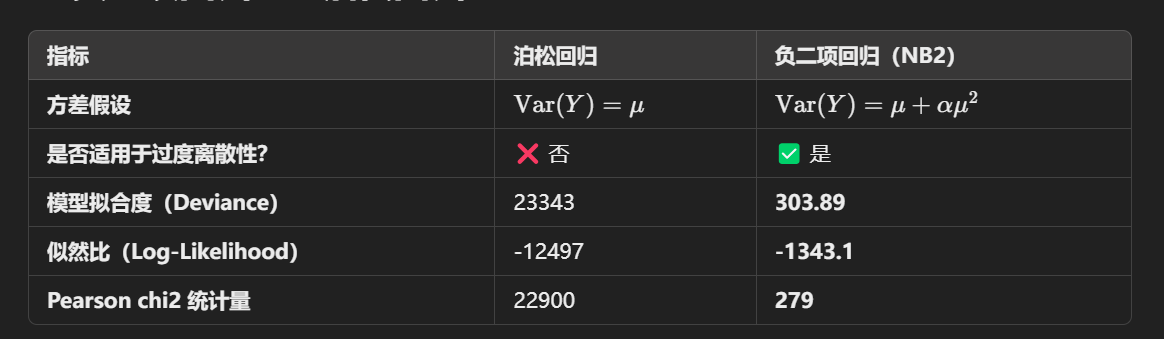
Deviance（303.89）和 Pearson chi2（279）比泊松回归小很多，说明模型更合理。对数似然（Log-Likelihood, LL）越大越好

In [ ]:
#train the NB2 model on the training data set
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()
#print the training summary

print("chi-square p-value test Ho model vs saturated model If < 0.05 reject Ho model is a poor fit. :",1-chi2.cdf(nb2_training_results.pearson_chi2,(nb2_training_results.df_resid-len(X_train.columns))))

print(nb2_training_results.summary())

#make some predictions using our trained NB2 model
nb2_predictions = nb2_training_results.get_prediction(X_test)

#print out the predictions
predictions_summary_frame = nb2_predictions.summary_frame()
#print(predictions_summary_frame)

chi-square p-value test Ho model vs saturated model If < 0.05 reject Ho model is a poor fit. : 2.343392369041908e-09
                 Generalized Linear Model Regression Results                  
Dep. Variable:               BB_COUNT   No. Observations:                  167
Model:                            GLM   Df Residuals:                      160
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1343.1
Date:                Sun, 27 Mar 2022   Deviance:                       303.89
Time:                        14:50:14   Pearson chi2:                     279.
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------

The plot below shows that the predictions follow the overall trend.

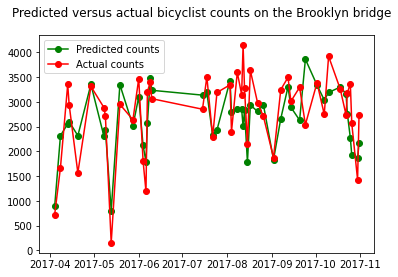

In [ ]:

#plot the predicted counts versus the actual counts for the test data
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['BB_COUNT']
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

Have a go at implementing a NB1 model. As usual leave your thoughts on the comments board.

References:

[1] Cameron, A.C. and Trivedi, P.K., 1986. Econometric models based on count data. Comparisons and applications of some estimators and tests. Journal of applied econometrics, 1(1), pp.29-53.

[2] A. Colin Cameron and Pravin K. Trivedi  REGRESSION ANALYSIS OF COUNT DATA
Second Edition
